In [1]:
import numpy as np
import matplotlib.pyplot as plt
import vaex 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
l = np.linspace(-180,180)
b = np.linspace(-90,90)

l,b = np.meshgrid(l,b)

In [3]:
# Petersen & Peñarrubia (2020) DOI: 10.1038/s41550-020-01254-3
vtravel = 32 # km/s
l_apex  = 56 # deg
b_apex = -34 # deg

pi = np.pi
deg2rad = pi/180

cos_l, sin_l = np.cos(np.deg2rad(l_apex)), np.sin(np.deg2rad(l_apex))
cos_b, sin_b = np.cos(np.deg2rad(b_apex)), np.sin(np.deg2rad(b_apex))


vx_apex = - vtravel * cos_l * cos_b
vy_apex = - vtravel * sin_l * cos_b
vz_apex = - vtravel * sin_b

In [4]:
df = vaex.from_arrays(l = l.ravel(), b = b.ravel(), 
                      distance = np.ones_like(l).ravel())

In [5]:
# First some lines to calculate the imprints of the solar motion w.r.t. the LSR as a function of (l,b)
U=11.1  # From Schoenrich+2010
V=12.24 # From Schoenrich+2010
W=7.25  # From Schoenrich+2010
k = 4.74057
Rsun = 8.2

df.add_variable("vx_sun", U); vx_sun = U
df.add_variable("vy_sun", V); vy_sun = V
df.add_variable("vz_sun", W); vz_sun = W
df.add_variable("k", k)
df.add_variable("pi", np.pi)

df['x'] = df['cos(l*pi/180)'] * df['cos(b*pi/180)']
df['y'] = df['sin(l*pi/180)'] * df['cos(b*pi/180)']
df['z'] = df['sin(b*pi/180)']

df.add_virtual_column("vl_sun", f"-{vx_sun} * sin(l*pi/180) + {vy_sun} * cos(l*pi/180)")
df.add_virtual_column("vb_sun", f"cos(b * pi/180) * {vz_sun} - sin(b * pi/180) * ({vx_sun} * cos(l*pi/180) + {vy_sun} * sin(l*pi/180))")
df.add_virtual_column('radial_velocity_sun',f'(x*{vx_sun}+y*{vy_sun}+z*{vz_sun})/distance')

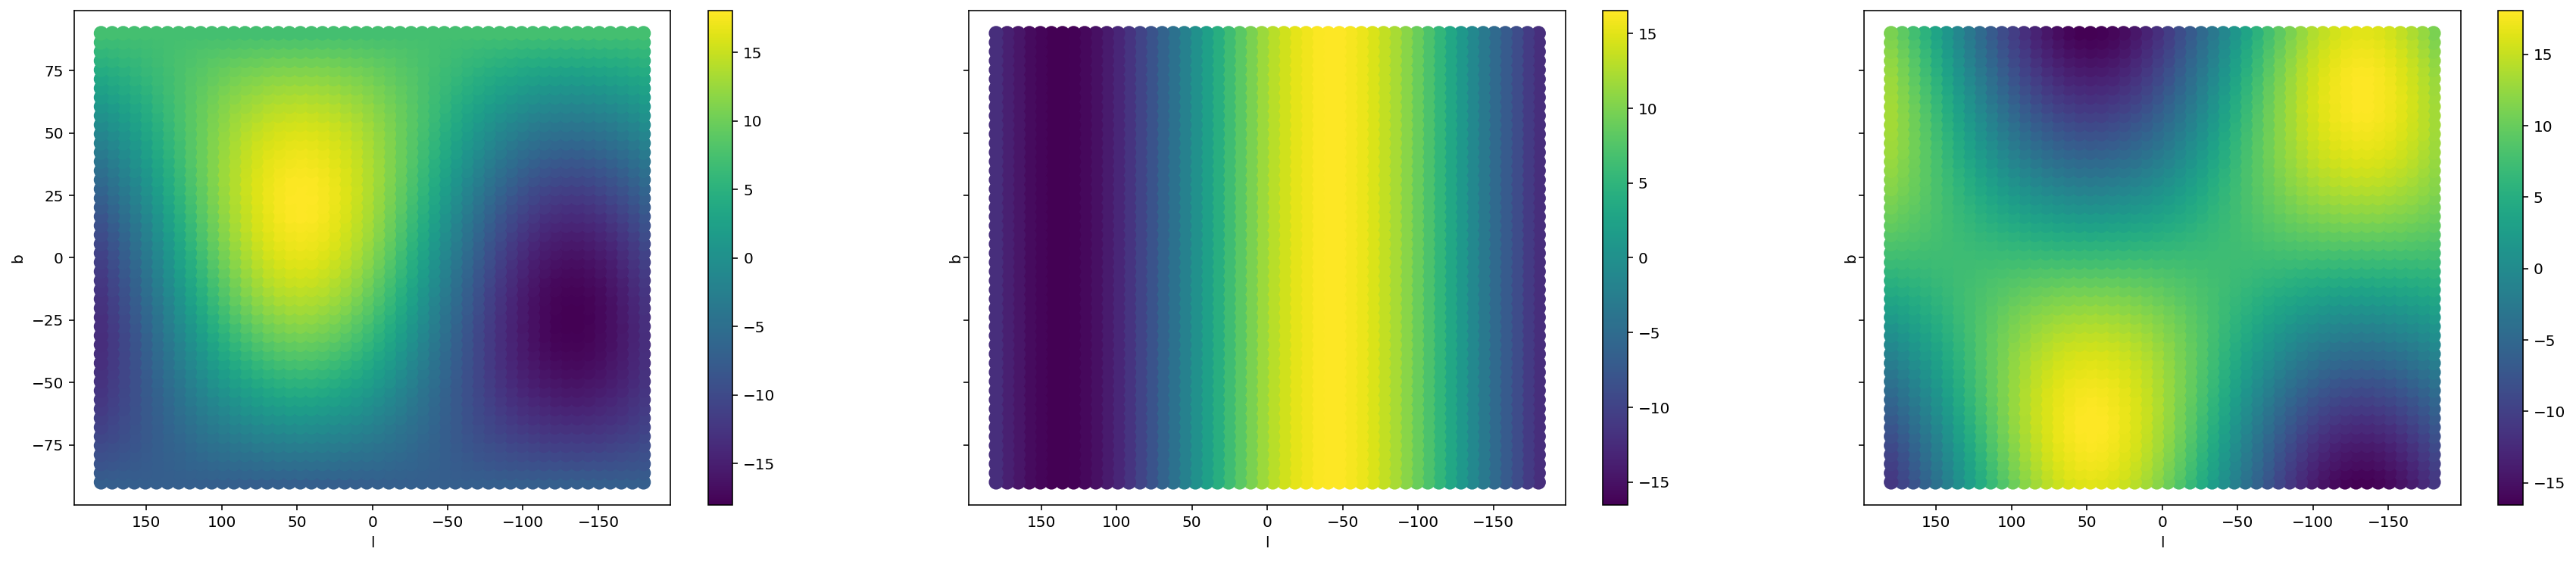

In [6]:
fig, axes = plt.subplots(ncols=3, figsize=(30,6), sharex=True, sharey=True)
plt.sca(axes[0])
cim = df.scatter('l','b',c_expr='radial_velocity_sun', s=75)
plt.colorbar(cim)

plt.sca(axes[1])
cim = df.scatter('l','b',c_expr='vl_sun', s=75)
plt.colorbar(cim)

plt.sca(axes[2])
cim = df.scatter('l','b',c_expr='vb_sun', s=75)
plt.colorbar(cim)

axes[0].invert_xaxis()

In [7]:
df.add_variable("vx_apex", vx_apex)
df.add_variable("vy_apex", vy_apex)
df.add_variable("vz_apex", vz_apex)

df.add_virtual_column("vl_apex", f"-{vx_apex} * sin(l*pi/180) + {vy_apex} * cos(l*pi/180)")
df.add_virtual_column("vb_apex", f"cos(b * pi/180) * {vz_apex} - sin(b * pi/180) * ({vx_apex} * cos(l*pi/180) + {vy_apex} * sin(l*pi/180))")
df.add_virtual_column('radial_velocity_apex',f'(x*{vx_apex}+y*{vy_apex}+z*{vz_apex})/distance')


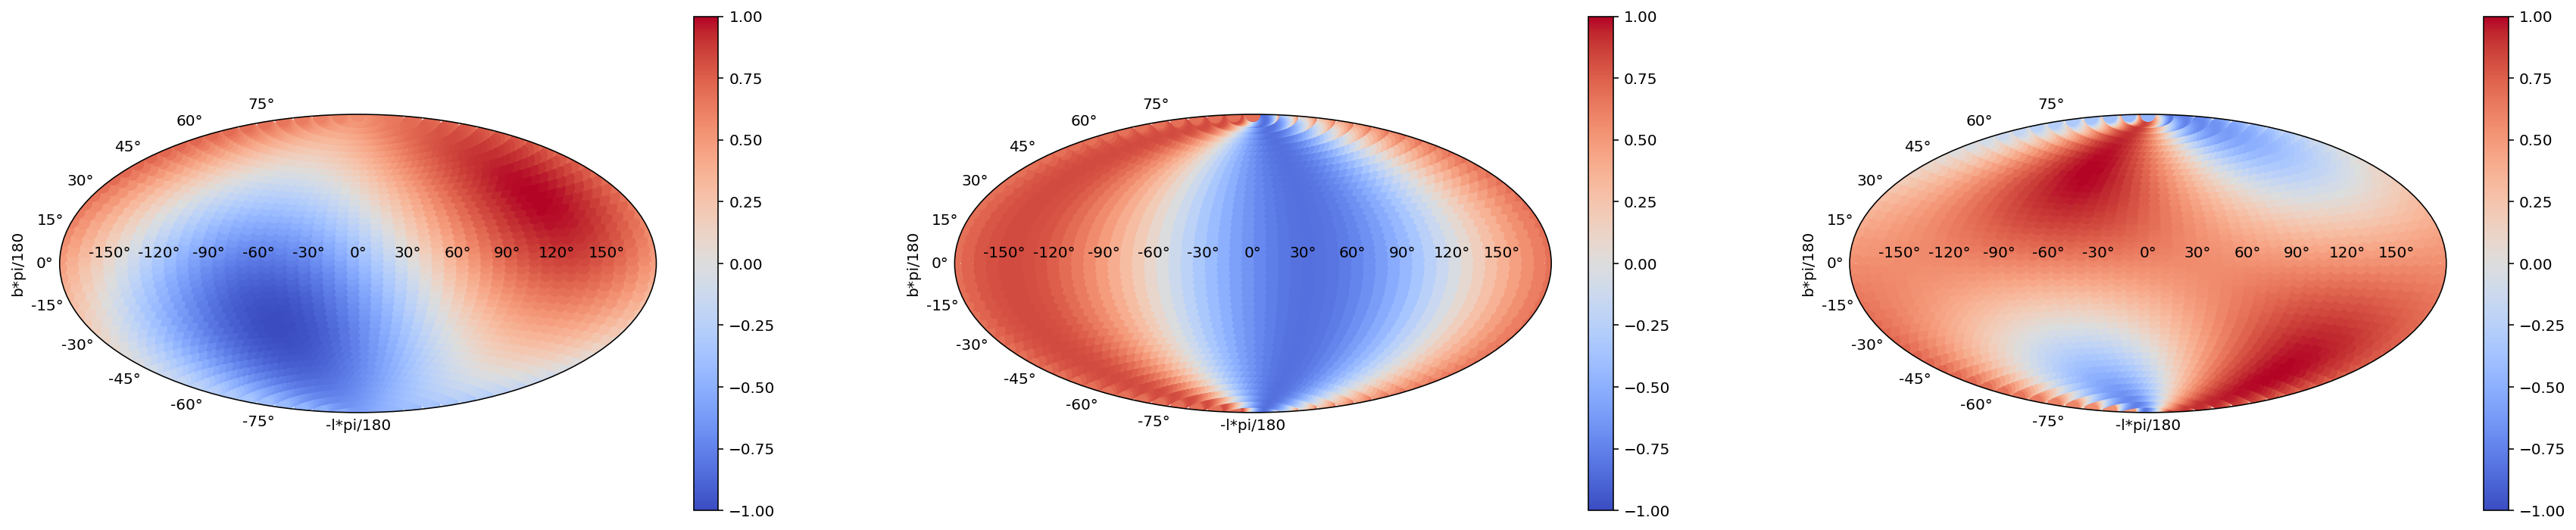

In [8]:
# Sanity check with Extended Data Fig. 8 of Petersen & Peñarrubia (2020) 
# https://arxiv.org/abs/2011.10581

fig, axes = plt.subplots(ncols=3, figsize=(30,6), subplot_kw={'projection': 'aitoff'})#, sharex=True, sharey=True)
plt.sca(axes[0])
cim = df.scatter('-l*pi/180','b*pi/180',c_expr=f'radial_velocity_apex/{abs(vtravel)}', s=75, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(cim)

plt.sca(axes[1])
cim = df.scatter('-l*pi/180','b*pi/180',c_expr=f'vl_apex/{abs(vtravel)}', s=75, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(cim)

plt.sca(axes[2])
cim = df.scatter('-l*pi/180','b*pi/180',c_expr=f'vb_apex/{abs(vtravel)}', s=75, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(cim)

In [9]:
def LMC_apex_motion_Galactic(l,b):
    """
    Input in degrees
    """
    
    # Petersen & Peñarrubia (2020) DOI: 10.1038/s41550-020-01254-3
    vtravel = 32 # km/s  
    l_apex  = 56 # deg
    b_apex = -34 # deg

    pi = np.pi
    deg2rad = pi/180

    cos_l, sin_l = np.cos(np.deg2rad(l_apex)), np.sin(np.deg2rad(l_apex))
    cos_b, sin_b = np.cos(np.deg2rad(b_apex)), np.sin(np.deg2rad(b_apex))

    # These are divided by the distance (it cancels in the equation for vr)
    x = np.cos(l*pi/180) * np.cos(b*pi/180)
    y = np.sin(l*pi/180) * np.cos(b*pi/180)
    z = np.sin(b*pi/180)
    
    # Note sign!
    vx_apex = - vtravel * cos_l * cos_b
    vy_apex = - vtravel * sin_l * cos_b
    vz_apex = - vtravel * sin_b

    
    

    vl_apex = -vx_apex * np.sin(l*pi/180) + vy_apex * np.cos(l*pi/180)
    vb_apex = np.cos(b * pi/180) * vz_apex - np.sin(b * pi/180) * (vx_apex * np.cos(l*pi/180) + vy_apex * np.sin(l*pi/180))
    radial_velocity_apex = (x*vx_apex+y*vy_apex+z*vz_apex)
    
    return radial_velocity_apex, vl_apex, vb_apex

In [10]:
# From Torrealba+2019
l_Antlia = 264.8955
b_Antlia = 11.2479

In [11]:
radial_velocity_apex, vl_apex, vb_apex = LMC_apex_motion_Galactic(l_Antlia, b_Antlia)

In [12]:
pm_l, pm_b = vl_apex/130/k, vb_apex/130/k
pm_l, pm_b

(-0.020801250559843866, 0.02112706316835667)